In [1]:
import sys
sys.path.append("../../")

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from botorch.utils.sampling import draw_sobol_samples

from optimizers.lfbo.lfbo_joint_rand import LFBO_JointRand

tkwargs = {"device": "cpu:0", "dtype": torch.double}

In [3]:
def forrester(x, noise_level=.2):
    f = np.sin(3*x) + x**2 - 0.7*x + np.random.normal(0, noise_level, x.shape)
    return f

bounds = torch.tensor([[-1.], [2.]], **tkwargs)

In [4]:
x_dense = torch.linspace(-1, 2, 512, **tkwargs).reshape(-1, 1)
y_dense = forrester(x_dense, noise_level=0)

In [5]:
num_obs = 32
x_obs = draw_sobol_samples(bounds=bounds, n=num_obs, q=1, seed=123).squeeze(-2)
y_obs = forrester(x_obs, noise_level=0.0)

In [6]:
lfbo_joint_rand = LFBO_JointRand(input_dim=1, output_dim=1, weight_type='pi', interpolation='linear', **tkwargs)

In [7]:
lfbo_joint_rand.fit(x_obs, y_obs, S=10000)

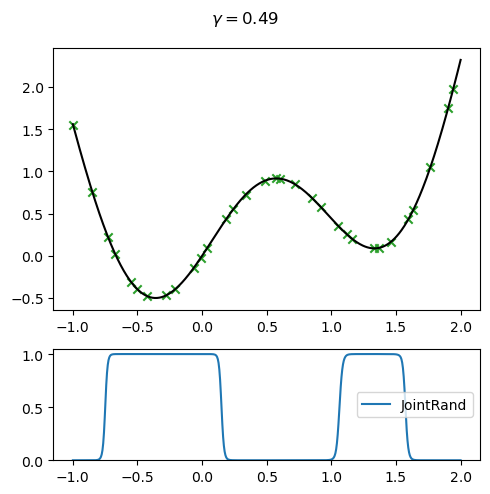

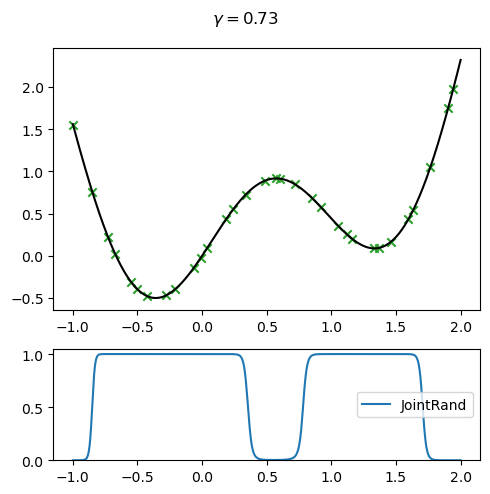

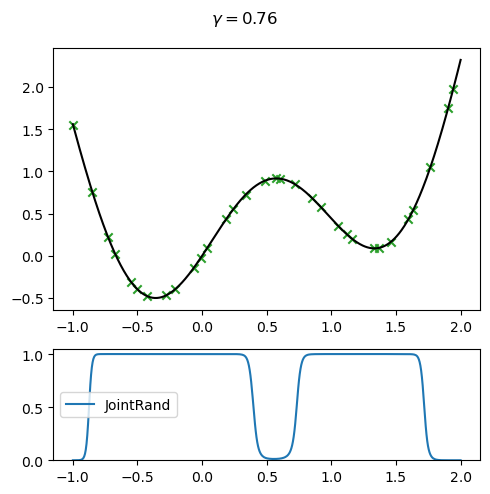

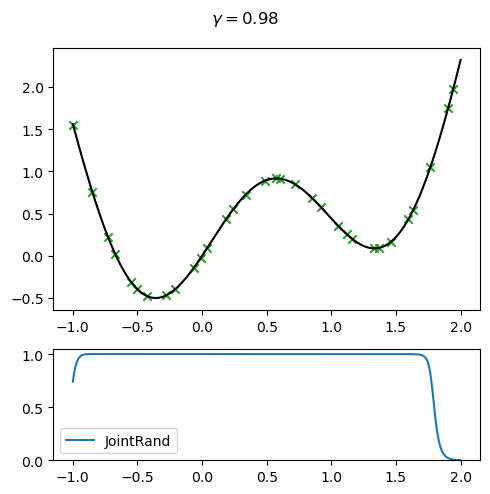

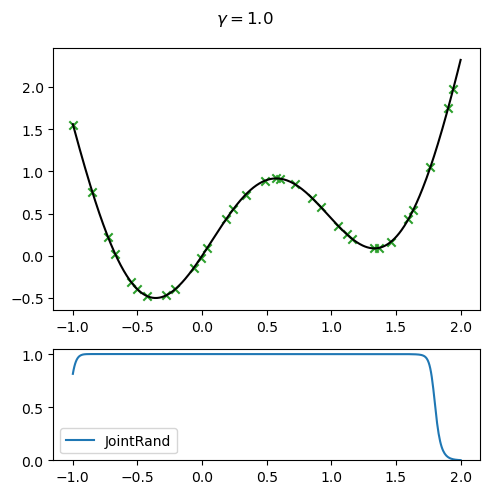

In [8]:
gammas, _ = torch.sort(torch.rand(5, **tkwargs))

for gamma in gammas:
    fig = plt.figure(figsize=(5, 5))
    ax_func = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax_func.plot(x_dense, y_dense, color='k', label="objective function")
    ax_func.scatter(x_obs, y_obs, marker='x', color='tab:green', label="observations")

    ax_lfbo = plt.subplot2grid((3, 1), (2, 0), rowspan=1, sharex=ax_func)

    acf_joint_rand = lfbo_joint_rand.predict(x_dense, gamma=gamma)
    ax_lfbo.plot(
        x_dense,
        acf_joint_rand,
        label="JointRand",
    )
    ax_lfbo.set_ylim(0., 1.05)
    ax_lfbo.legend()
    fig.suptitle(rf'$\gamma = {gamma:.02}$')
    plt.tight_layout()
    plt.show()

In [19]:
taus = []
# inputs = torch.tensor([[-0.5]], **tkwargs)
inputs = x_dense

quantile = .5 * torch.ones(len(inputs), **tkwargs).reshape(-1, 1)
quantile.requires_grad_()
targets = torch.tensor([0.5] * len(inputs), **tkwargs)

# # add batch dimension
# train_tensors = [x_obs, quantile.unsqueeze(1)]
# train_dataset = torch.utils.data.TensorDataset(*train_tensors)
# train_dataloader = torch.utils.data.DataLoader(train_dataset)

optimizer = torch.optim.Adam([quantile])
for p in lfbo_joint_rand.clf.parameters():
    p.requires_grad = False
loss_fn = torch.nn.MSELoss()

for epochs in range(1000):
    optimizer.zero_grad(set_to_none=True)
    logits = lfbo_joint_rand.clf(inputs, quantile)
    outputs = torch.sigmoid(logits)
    loss = loss_fn(
        outputs.squeeze(1), targets
    )
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        quantile.clamp_(0, 1)

taus = []
for q in quantile.detach():
    tau = torch.quantile(torch.unique(y_obs), q=q.item(), interpolation='linear')
    taus.append(tau.item())

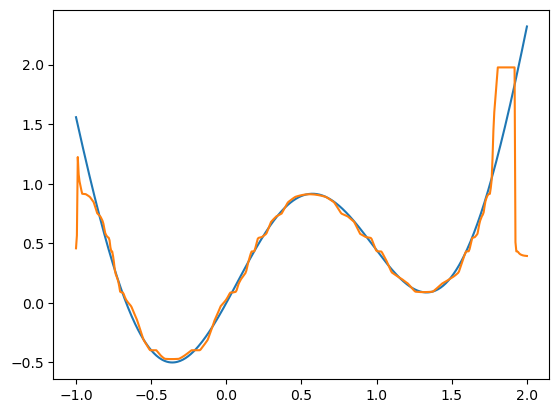

In [20]:
plt.plot(x_dense, y_dense)
plt.plot(x_dense, taus);